[前節](0401_penguins.qmd)では、ペンギンデータを可視化し、データの特徴を把握しました。このデータを使って、ペンギンの種類を分類する機械学習モデルを構築しましょう。

PythonのScikit-learnライブラリには機械学習モデルの構築から評価に必要な機能が含まれています。そのため今回はScikit-learnライブラリを使ってペンギンデータを分類する機械学習モデルを構築します。


In [1]:
#| eval: true
#| echo: false
from IPython.display import Markdown, display

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learnのライブラリ
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
penguins = sns.load_dataset("penguins")

## scikit-learnを使った機械学習モデルの構築

ペンギンデータをロジスティック回帰モデルによって分類します。

### 前処理

具体的には欠損値への対応とラベルエンコーディングを実行します。

ロジスティック回帰など、いくつかの機械学習モデルは欠損値を含むデータを直接扱うことができません。そのため、欠損値を含む行を削除するか、欠損値を別の値に置き換える必要があります。今回はpandasの`dropna()`関数で欠損値を含む行を削除します。


In [4]:
#| label: 前処理その1

# 1/2 欠損値を含む行を削除
penguins.dropna(inplace=True)  # 元のデータフレームを書き換える場合、inplace=Trueを指定する

# 11行削除されていることを確認
penguins.shape

(333, 7)

続いてラベルエンコーディングを適用します。ラベルエンコーディングとは、カテゴリ変数を数値に変換する処理です。例えば、`species`列の値Adelie、Chinstrap、Gentooをそれぞれ0, 1, 2に変換します。機械学習モデルは数値データを扱うため、カテゴリ変数を数値に変換する必要があります。ペンギンデータの場合、`species`の他に`island`や`sex`列もカテゴリ変数なのでラベルエンコーディングを適用対象となります。ラベルエンコーディングはscikit-learnの`LabelEncoder`クラスを使って実行します。


In [5]:
#| label: 前処理その2
# 2/2 ラベルエンコーディング
# LabelEncoderクラスのインスタンスを作成
le = LabelEncoder()
# 以下のコードの実行で、species列の値Adelie、Chinstrap、Gentooがそれぞれ0, 1, 2に変換される
penguins["species"] = le.fit_transform(penguins["species"])
# island列とsex列についても同様にラベルエンコーディングを実行
penguins["island"] = le.fit_transform(penguins["island"])
penguins["sex"] = le.fit_transform(penguins["sex"])


# 前処理を行ったデータを表示
# ラベルエンコーディングが適用された3列に注目
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...,...,...
338,2,0,47.2,13.7,214.0,4925.0,0
340,2,0,46.8,14.3,215.0,4850.0,0
341,2,0,50.4,15.7,222.0,5750.0,1
342,2,0,45.2,14.8,212.0,5200.0,0


| 元の値 | ラベルエンコーディング後の値 |
|-------|-------------------------|
| Adelie | 0 |
| Chinstrap | 1 |
| Gentoo | 2 |

### データ分割

- 訓練データ: モデルの学習に用いるデータ。モデルはこのデータの特徴を学習し、テストデータに対する予測を行うためのパラメータを決定する。
- テストデータ: モデルの予測精度を評価するためのデータ。モデルの学習には用いられない。


In [6]:
# 目的変数をspecies列、説明変数をspecies列以外の列とする
# X... 説明変数のみからなるデータフレーム
# y... 目的変数のみからなるデータフレーム
X = penguins.drop(columns="species")
y = penguins["species"]

# 訓練データとテストデータに分割
# test_sizeでテストデータの割合を指定する。ここでは全体の20%をテストデータとする（80%を訓練データとする）
# random_stateは乱数のシードを指定する引数。この値を変更すると結果が変わるので注意
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=20230508
)

### モデルの構築

sklearn.linear_modelモジュールのLogisticRegressionを使ってロジスティック回帰モデルを構築します。


In [7]:
# ロジスティック回帰モデルを適用し、モデルを訓練
# max_iter引数でパラメータ探索のための試行回数を設定（デフォルトでは100）
lr = LogisticRegression(max_iter=1000)
# 訓練データを使ってモデルを訓練
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### モデルの予測

構築したモデルに対して、テストデータを使って予測を行います。`lr.predict(X_test)`を実行すると、テストデータに対する予測結果が得られます。


In [8]:
# テストデータを使って予測を行う
y_pred = lr.predict(X_test)

# 予測結果は配列で格納されている
y_pred

array([1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0,
       1, 1, 2, 0, 2, 2, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2, 0, 2,
       2])

ロジスティック回帰モデルでは、各クラス（ここではペンギンの種名）に属する確率を出力することもできます。構築したモデルのインスタンスと`predict_proba()`関数を実行すると、各データポイントに対するクラスの所属確率を配列として取得できます。


In [9]:
# テストデータがどのクラスに属するかの確率を出力
probabilities = lr.predict_proba(X_test)

ペンギンの種名は3つのクラスに分類されるので、`predict_proba()`関数の出力は3列の配列となります。各データポイントに対して、それぞれのクラスに属する確率が出力されています。このうち、最も確率が高いクラスが予測結果となります。


In [10]:
# テストデータの一件目のデータポイントに対するクラス別の所属確率
# 表示を見やすくするために、小数点以下4桁まで表示するように設定
np.set_printoptions(suppress=True, formatter={"float": "{:.4f}".format})
print(probabilities[0])

[0.0010 0.9986 0.0004]


In [11]:
# 実際の予測結果
y_pred[0]

1

## モデルの評価


In [12]:
# 真の値であるy_testと予測値のy_predを比較して2つの値がどの程度一致しているかを確認する
# y_testをデータフレームに変換
y_test_df = pd.DataFrame(y_test)
# y_predをデータフレームに変換
y_pred_df = pd.DataFrame(y_pred, columns=["predicted"], index=y_test.index)

# y_testとy_predのデータフレームを結合
comparison_df = pd.concat([y_test_df, y_pred_df], axis=1)

# speciesとpredictedが一致しているかどうかを確認
comparison_df["correct"] = comparison_df["species"] == comparison_df["predicted"]

# TrueとFalseの数をカウント
comparison_df.groupby("correct").size().reset_index(name="count")

,correct,count
0,False,1
1,True,66


In [13]:
#| echo: false
predict_match = (
    comparison_df.groupby("correct").size().reset_index(name="count")["count"][1]
)
display(
    Markdown(
        """
一致した件数は {predict_match}/{total_n}件です。これは、モデルが正しく予測できたデータの割合が約98%であることを意味します。
""".format(
            predict_match=predict_match, total_n=len(comparison_df)
        )
    )
)


一致した件数は 66/67件です。これは、モデルが正しく予測できたデータの割合が約98%であることを意味します。


scikit-learnには、モデルの評価を行うための様々な関数が用意されています。ここでは、sklearn.metricsモジュールの関数を使ってモデルの評価を行います。

`accuracy_score()`関数は、正解率を計算する関数です。正解率は、正しく予測できたデータの割合を表します。この値は先ほど確認した正解率と一致します。


In [14]:
# モデルを評価
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9850746268656716


種名ごとの精度を確認するために`classification_report()`関数を使います。


In [15]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        24

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67



各クラスごとに、
precision、recall、f1-score、supportの4つの値が表示されます。それぞれの値の意味は以下の通りです。

- precision: 適合率。正と予測したデータのうち、実際に正であるものの割合。
- recall: 再現率。実際に正であるもののうち、正であると予測されたものの割合。
- f1-score: 適合率と再現率の調和平均により得られた値。適合率と再現率のバランスを考慮した評価指標。この値が高いほど、適合率と再現率の両方が高いことを示す。
- support: 分類されたデータ数。

ここで出力される評価指標については`accuracy_score()`関数のように個別の関数を使った算出も可能です。具体的にはprecisionは`precision_score()`、recallは`recall_score()`、f1-scoreは`f1_score()`関数を利用して求めます。


In [16]:
#| eval: false
#| echo: true
#| code-fold: false
print("Precision:", precision_score(y_test, y_pred, average=None))
print("Recall:", recall_score(y_test, y_pred, average=None))
print("F1-Score:", f1_score(y_test, y_pred, average=None))

### 混合行列

最後に、分類モデルの性能評価に使われる混合行列を確認しましょう。混合行列は、モデルの予測結果と実際のクラスの関係を4つの要素に分類した行列です。以下の4つの要素に分類されます。

- True Positive（TP）：正のクラスを正と予測し、実際に正である場合。
- False Positive（FP）：正のクラスを正と予測したが、実際には負である場合。
- True Negative（TN）：負のクラスを負と予測し、実際に負である場合。
- False Negative（FN）：負のクラスを負と予測したが、実際には正である場合。

scikit-learnでは、`confusion_matrix()`関数を使って混合行列を作成できます。ここではさらに、`ConfusionMatrixDisplay()`関数を使って混合行列を可視化する例を示します。


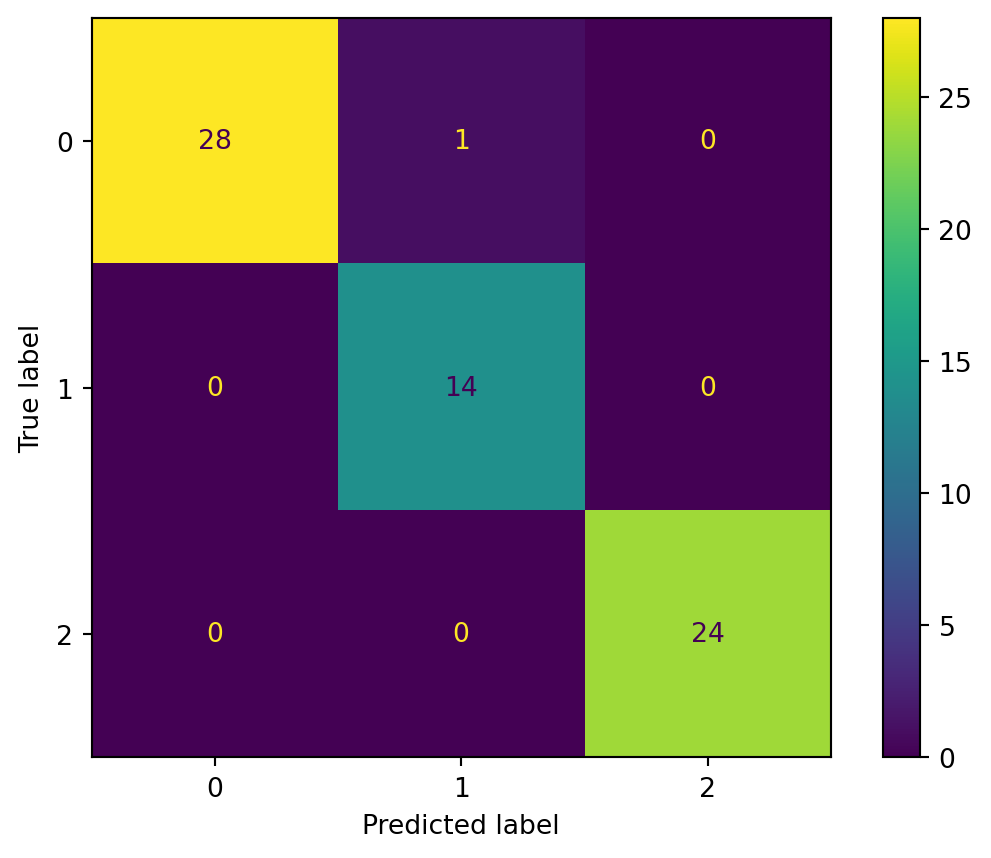

In [17]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

disp.plot()
plt.show()

混合行列を見ることで、どのクラスが誤分類されやすいかを確認することができます。また、適合率や再現率の値がどのように計算されているかを理解することができます。

具体的には以下のように計算されます。

- 適合率: TP / (TP + FP)
- 再現率: TP / (TP + FN)

今回構築したロジスティック回帰モデルでの適合率を計算してみましょう。ここでは、ペンギンデータの3種のラベルそれぞれの適合率を以下のように計算します。


In [18]:
for i in range(3):  # ラベルは0, 1, 2の3種類
    # True Positiveの数
    TP = np.sum((y_pred == i) & (np.array(y_test) == i))

    # False Positiveの数
    FP = np.sum((y_pred == i) & (np.array(y_test) != i))

    # Precisionの計算
    precision = TP / (TP + FP)

    print(f"Precision for label {i}: {precision}")

Precision for label 0: 1.0
Precision for label 1: 0.9333333333333333
Precision for label 2: 1.0


このラベルごとの適合率を平均した値が、モデルの適合率となります。`precision_score()`関数はデフォルトでラベルごとの適合率を計算しますが、`average`引数を指定することで、ラベルごとの適合率の平均値を求めることができます。


In [19]:
print("Average Precision:", precision_score(y_test, y_pred, average="macro"))

Average Precision: 0.9777777777777779


::: {.callout-note}
- 数値変数の標準化、ラベルエンコーディングの代わりにダミー変数化を行ったデータでモデルの学習を行いましょう。

:::